## Example operational analysis using the augmented capabilities of the AEP class

In [1]:
%load_ext autoreload
%autoreload 2

This notebook provides an overview and walk-through of the augmented capabilities which have been added to the plant-level operational energy asssessment (OA) of a wind plant in the PRUF project. The La Haute-Borne wind farm is used here and throughout the example notebooks. 

The overall structure of the notebook follows the walk-through in the standard AEP example notebook '02_plant_aep_analysis,' to which we refer the reader for a detailed description of the steps needed to prepare the analysis. Here, we focus on the application of various approaches in the AEP calculation, with different time resolutions, regression inputs and regression models used.

In [2]:
# Import required packages
import os
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import pandas as pd
import copy

from project_ENGIE import Project_Engie
from operational_analysis.methods import plant_analysis

/Users/esimley/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In the call below, make sure the appropriate path to the CSV input files is specfied. In this example, the CSV files are located directly in the 'examples/operational_AEP_analysis/data' folder.

In [3]:
# Load plant object
project = Project_Engie('./data/la_haute_borne')

In [4]:
# Prepare data
project.prepare()

INFO:project_ENGIE:Loading SCADA data
INFO:operational_analysis.types.timeseries_table:Loading name:la-haute-borne-data-2014-2015
INFO:project_ENGIE:SCADA data loaded
INFO:project_ENGIE:Timestamp QC and conversion to UTC
INFO:project_ENGIE:Correcting for out of range of temperature variables
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:project_ENGIE:Flagging unresponsive sensors
INFO:project_ENGIE:Converting field names to IEC 61400-25 standard
INFO:operational_analysis.types.timeseries_table:Loading name:plant_data
INFO:operational_analysis.types.timeseries_table:Loading name:plant_data
INFO:operational_analysis.types.timeseries_table:Loading name:merra2_la_haute_borne
INFO:operational_analysis.types.timeseries_table:Loading name:era5_wind_la_haute_borne


### Comparison 1: AEP calculation using different regression models and different time resolution


The updated AEP class includes the choice of four different regression algorithms to calculate the long-term OA. The choice is based on what is specified by the reg_model parameter:
- linear regression (reg_model = 'lin', default)
- generalized additive regression model (reg_model = 'gam')
- gradient boosting regressor (reg_model = 'gbm')
- extremely randomized trees model (reg_model = 'etr')

Linear regression can be selected without restrictions, but should only be used at monthly resolution, since wind plant power curves are not linear at fine time resolution. On the other hand, as machine learning models are more suited for problems with a large number of data points, we have restricted the use of gam, gbm and etr regressors to OA performed at daily and hourly resolution only.

Here, we'll calculate AEP using all four regression models, using only wind speed as input (Comparison 2 will show an example of a multivariate regression). The linear regression model is run at monthly resolution; the GBM and ETR models at daily resolution; the GAM model at hourly resolution.

In [5]:
pa_lin = plant_analysis.MonteCarloAEP(project, reanal_products = ['merra2','era5'], time_resolution = 'M',
                                    reg_temperature = False, reg_winddirection = False, reg_model = 'lin')

pa_gam = plant_analysis.MonteCarloAEP(project, reanal_products = ['merra2','era5'], time_resolution = 'H',
                                     reg_temperature = False, reg_winddirection = False, reg_model = 'gam')

pa_gbm = plant_analysis.MonteCarloAEP(project, reanal_products = ['merra2','era5'], time_resolution = 'D', 
                                         reg_temperature = False, reg_winddirection = False, reg_model = 'gbm')

pa_etr = plant_analysis.MonteCarloAEP(project, reanal_products = ['merra2','era5'], time_resolution = 'D',
                                            reg_temperature = False, reg_winddirection = False, reg_model = 'etr')

INFO:operational_analysis.methods.plant_analysis:Initializing MonteCarloAEP Analysis Object
INFO:operational_analysis.methods.plant_analysis:Initializing MonteCarloAEP Analysis Object
INFO:operational_analysis.methods.plant_analysis:Initializing MonteCarloAEP Analysis Object
INFO:operational_analysis.methods.plant_analysis:Initializing MonteCarloAEP Analysis Object


As an example, the monthly data frame below includes wind speed averages for both the reanalysis products selected for the analysis.

In [6]:
# View the monthly data frame
pa_lin._aggregate.df.head()

,energy_gwh,energy_nan_perc,num_days_expected,num_days_actual,availability_gwh,curtailment_gwh,gross_energy_gwh,availability_pct,curtailment_pct,avail_nan_perc,curt_nan_perc,nan_flag,availability_typical,curtailment_typical,combined_loss_valid,merra2,era5
time,,,,,,,,,,,,,,,,,
2014-01-01,1.279667,0.0,31,31,0.008721,0.000000,1.288387,0.006769,0.000000,0.0,0.0,False,True,True,True,7.227947,7.314878
2014-02-01,1.793873,0.0,28,28,0.005280,0.000000,1.799153,0.002934,0.000000,0.0,0.0,False,True,True,True,8.598686,8.347006
2014-03-01,0.805549,0.0,31,31,0.000151,0.000000,0.805700,0.000188,0.000000,0.0,0.0,False,True,True,True,5.207071,5.169673
2014-04-01,0.636472,0.0,30,30,0.002773,0.000000,0.639245,0.004338,0.000000,0.0,0.0,False,True,True,True,4.872304,4.756275
2014-05-01,1.154255,0.0,31,31,0.015176,0.000225,1.169656,0.012974,0.000192,0.0,0.0,False,True,True,True,6.351635,6.162751


We now run the Monte-Carlo based OA for the four setups specified above.
The following lines of code launch the Monte Carlo-based OA for AEP. We identify each source of uncertainty in the OA estimate and use that uncertainty to create distributions of the input and intermediate variables from which we can sample for each iteration of the OA code. 

We repeat the OA process "num_sim" times using different sampling combinations of the input and intermediate variables to produce a distribution of AEP values. Running the OA with the machine learning models at daily resolution is significantly slower than the case of a simple linear regression. Therefore, we have reduced the num_sim parameter to speed up the computation here. Once again, for a detailed description of the steps in the OA process, please refer to the standard AEP example notebook.


In [7]:
# Run Monte-Carlo based OA - linear monthly
pa_lin.run(num_sim=1000)
# Run Monte-Carlo based OA - gam model, hourly resolution
pa_gam.run(num_sim=500)
# Run Monte-Carlo based OA - gradient boosting model, daily resolution
pa_gbm.run(num_sim=500)
# Run Monte-Carlo based OA - extra randomized tree model, daily resolution
pa_etr.run(num_sim=500)

INFO:operational_analysis.methods.plant_analysis:Running with parameters: {'uncertainty_meter': 0.005, 'uncertainty_losses': 0.05, 'uncertainty_loss_max': array([10., 20.]), 'uncertainty_windiness': array([10., 20.]), 'uncertainty_nan_energy': 0.01, 'num_sim': 1000, 'reanal_subset': ['merra2', 'era5']}
100%|██████████| 1000/1000 [00:11<00:00, 84.29it/s]
INFO:operational_analysis.methods.plant_analysis:Run completed
INFO:operational_analysis.methods.plant_analysis:Running with parameters: {'uncertainty_meter': 0.005, 'uncertainty_losses': 0.05, 'uncertainty_loss_max': array([10., 20.]), 'uncertainty_windiness': array([10., 20.]), 'uncertainty_nan_energy': 0.01, 'num_sim': 500, 'reanal_subset': ['merra2', 'era5']}
  0%|          | 0/500 [00:00<?, ?it/s]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


  1%|          | 6/500 [00:11<16:07,  1.96s/it]  

Fitting 5 folds for each of 20 candidates, totalling 100 fits


100%|██████████| 500/500 [04:12<00:00,  1.98it/s]
INFO:operational_analysis.methods.plant_analysis:Run completed
INFO:operational_analysis.methods.plant_analysis:Running with parameters: {'uncertainty_meter': 0.005, 'uncertainty_losses': 0.05, 'uncertainty_loss_max': array([10., 20.]), 'uncertainty_windiness': array([10., 20.]), 'uncertainty_nan_energy': 0.01, 'num_sim': 500, 'reanal_subset': ['merra2', 'era5']}
  0%|          | 0/500 [00:00<?, ?it/s]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


  0%|          | 1/500 [00:27<3:52:42, 27.98s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


100%|██████████| 500/500 [04:43<00:00,  1.76it/s]
INFO:operational_analysis.methods.plant_analysis:Run completed
INFO:operational_analysis.methods.plant_analysis:Running with parameters: {'uncertainty_meter': 0.005, 'uncertainty_losses': 0.05, 'uncertainty_loss_max': array([10., 20.]), 'uncertainty_windiness': array([10., 20.]), 'uncertainty_nan_energy': 0.01, 'num_sim': 500, 'reanal_subset': ['merra2', 'era5']}
  0%|          | 0/500 [00:00<?, ?it/s]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


  0%|          | 1/500 [00:39<5:32:15, 39.95s/it]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


100%|██████████| 500/500 [07:27<00:00,  1.12it/s]
INFO:operational_analysis.methods.plant_analysis:Run completed


The key results for the AEP analysis are shown below: distributions of AEP values from which uncertainty can be deduced. We can now compare the AEP distributions obtained for the four configurations of the OA.

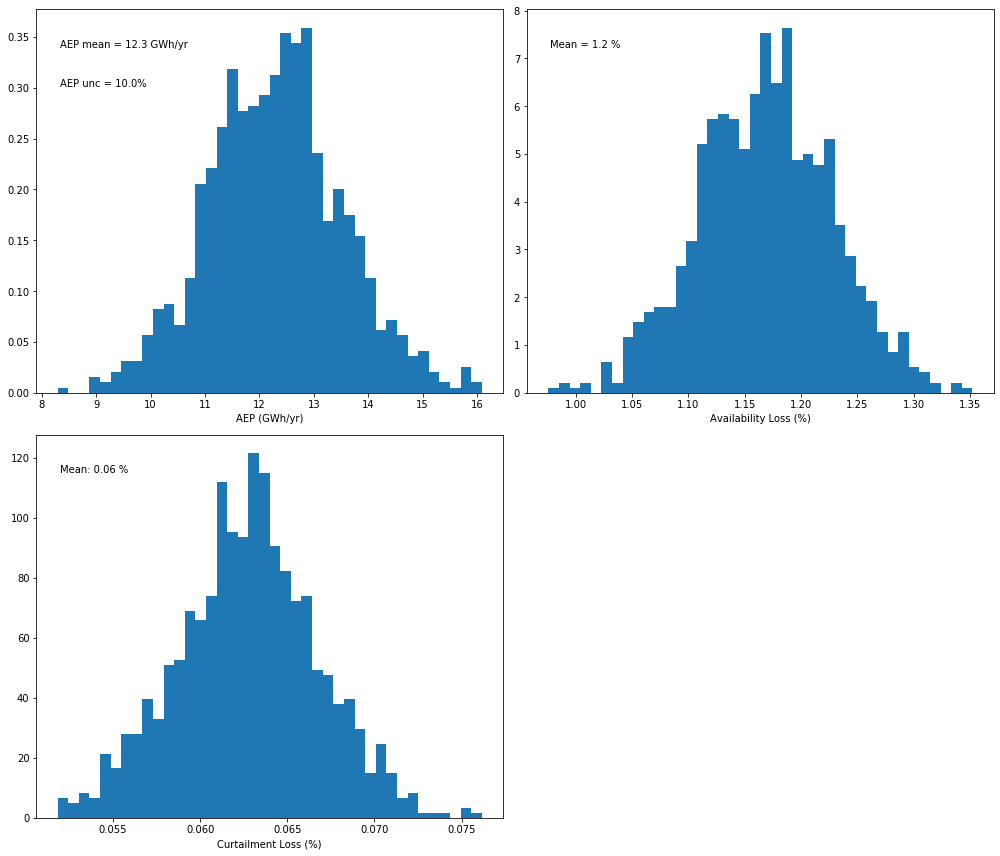

In [8]:
# Plot a distribution of AEP values from the Monte-Carlo OA method - wind speed only
pa_lin.plot_result_aep_distributions().show()

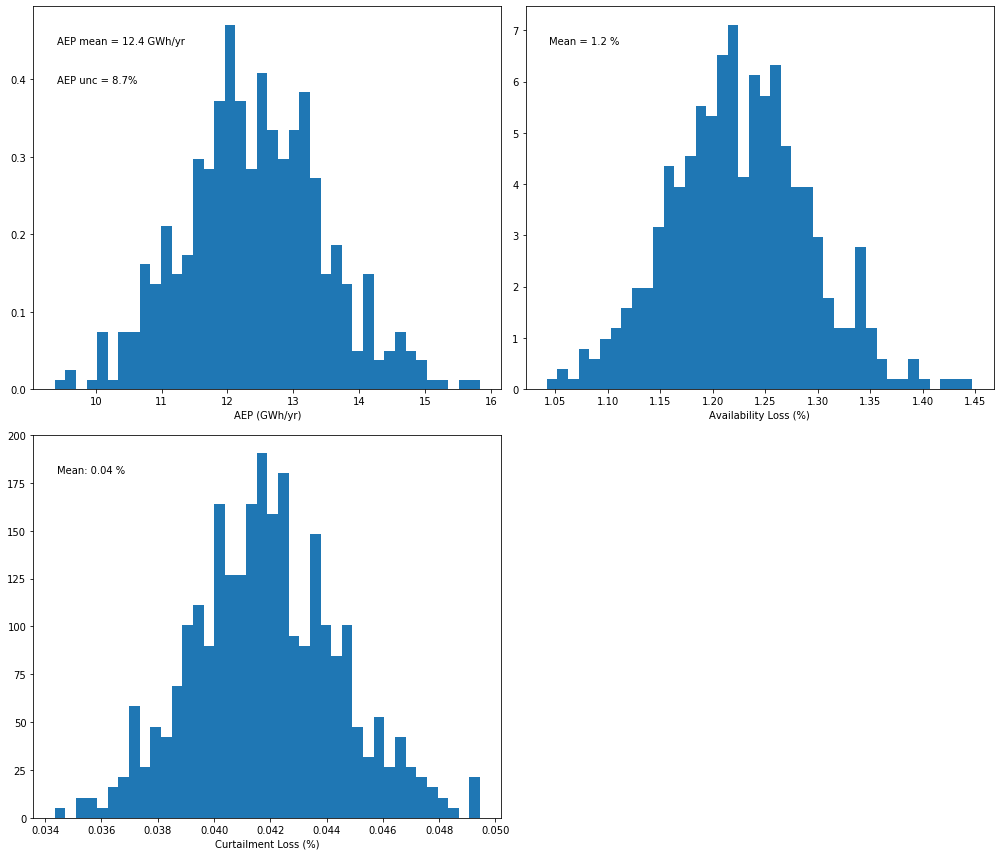

In [9]:
# Plot a distribution of AEP values from the Monte-Carlo OA method - gam model
pa_gam.plot_result_aep_distributions().show()

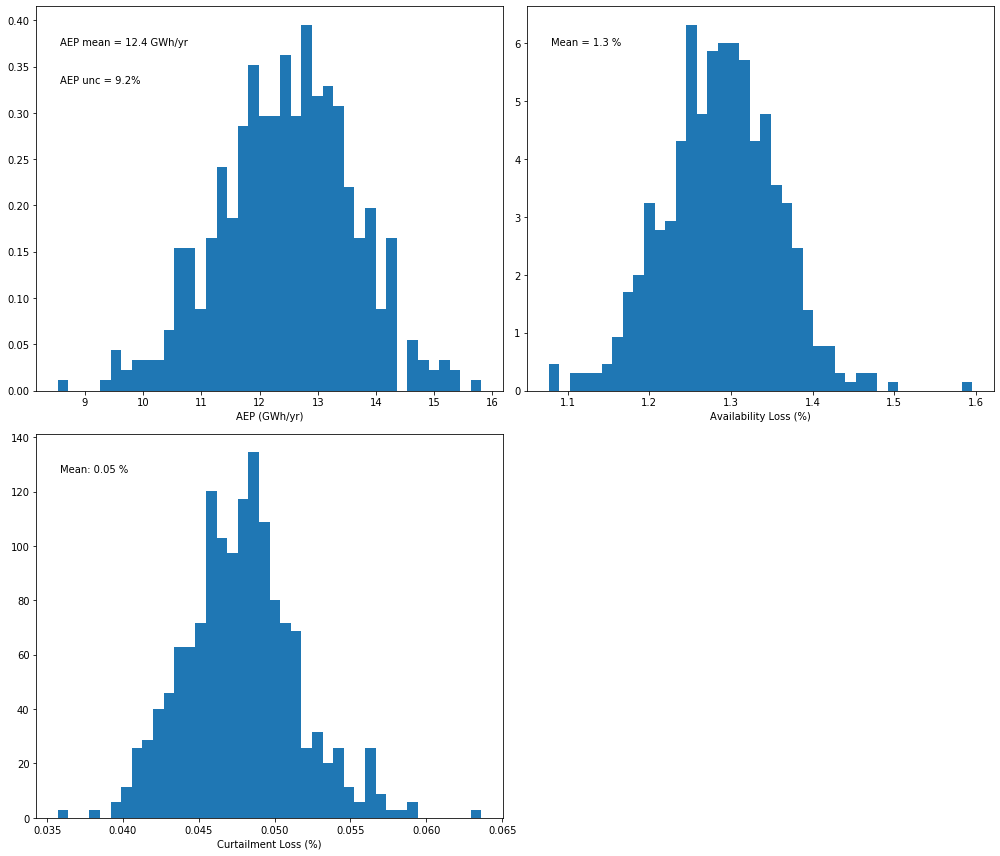

In [10]:
# Plot a distribution of AEP values from the Monte-Carlo OA method - gradient boosting model
pa_gbm.plot_result_aep_distributions().show()

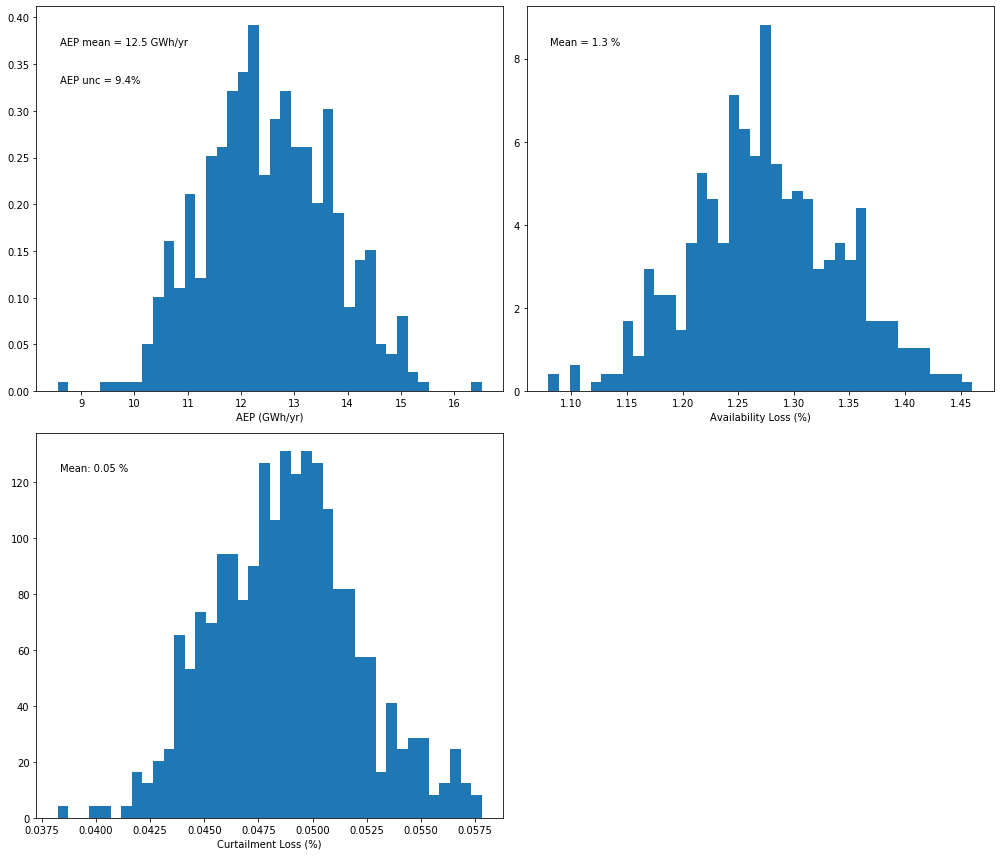

In [11]:
# Plot a distribution of AEP values from the Monte-Carlo OA method - extra randomized tree model
pa_etr.plot_result_aep_distributions().show()

For this specific case, we see a decrease in AEP uncertainty when the calculation is performed with a machine learning regression model at daily resolution, which becomes even more significant when performing the calculation at hourly resolution.

### Comparison 2: AEP calculation using various input variables



The augmented capabilities of the AEP class now allow the user to include temperature and/or wind direction as additional inputs to the long-term OA. 
This choice is controlled by the booleans "reg_temperature" and "reg_winddirection".
In this example, we will compute AEP using a multivariate hourly GAM regression, including wind speed and temperature as inputs, and compare the results with the univariate GAM applied in the previous comparison.

In [12]:
pa_gam_T = plant_analysis.MonteCarloAEP(project, reanal_products = ['merra2','era5'], time_resolution = 'H',
                                     reg_temperature = True, reg_winddirection = False, reg_model = 'gam')

INFO:operational_analysis.methods.plant_analysis:Initializing MonteCarloAEP Analysis Object


We now run the Monte-Carlo based OA for this new setup:

In [13]:
# Run Monte-Carlo based OA - gam model
pa_gam_T.run(num_sim=500)

INFO:operational_analysis.methods.plant_analysis:Running with parameters: {'uncertainty_meter': 0.005, 'uncertainty_losses': 0.05, 'uncertainty_loss_max': array([10., 20.]), 'uncertainty_windiness': array([10., 20.]), 'uncertainty_nan_energy': 0.01, 'num_sim': 500, 'reanal_subset': ['merra2', 'era5']}
  0%|          | 0/500 [00:00<?, ?it/s]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


  1%|          | 5/500 [00:20<38:35,  4.68s/it]  

Fitting 5 folds for each of 20 candidates, totalling 100 fits


100%|██████████| 500/500 [07:08<00:00,  1.17it/s]
INFO:operational_analysis.methods.plant_analysis:Run completed


And we can now take a look at the AEP distribution:

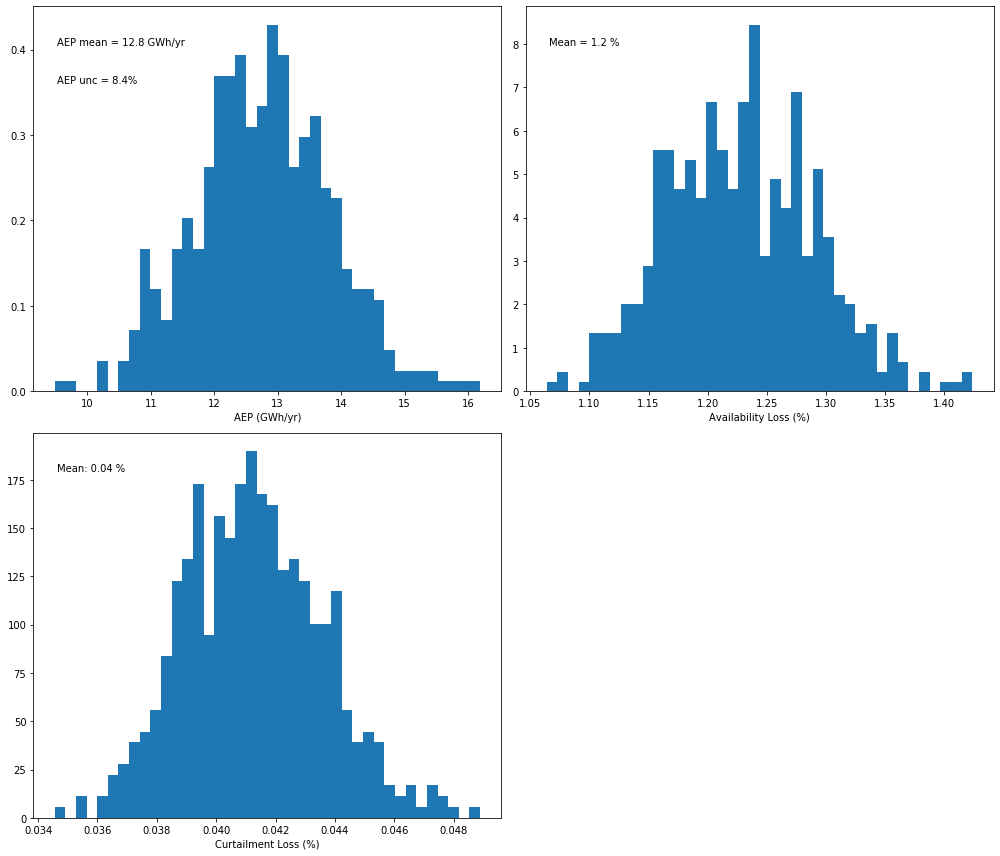

In [14]:
# Plot a distribution of AEP values from the Monte-Carlo OA method - wind speed + temperature + wind direction
pa_gam_T.plot_result_aep_distributions().show()

In this case, only a slight reduction in AEP uncertainty is achieved when temperature is added as additional input to the hourly GAM regression. Our analysis (Bodini et al. 2021, Wind Energy) showed how adding temperature as additional input has the largest benefits for those wind plants that experience a strong seasonal cycle, which might not be the case for the specific wind plant considered in this example.